# Micki Rhen HW1 - Classification models in sklearn

The goal of homework 1 is to build a classifier model to predict political party using other variables that have been provided

## Preliminaries

In [178]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import commonly used libraries and magic command for inline plotting

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [180]:
%matplotlib inline

## The Initial Tasks

### Task 1 - Create project folder structure

Task 1 involved creating a new project folder structure with the cookiecutter-datascience-simple template which was introduced in Module 1.


The following script was run from the directory of the new 'rhenhw1' project directory:

cookiecutter https://github.com/misken/cookiecutter-datascience-simple

![check](images/check.PNG)

### Task 2 - Put the new project folder under version control using git

After moving the supplied data to ...\rhenhw1\data\raw, the initial version control was implemented using the following commands:
    
    * git add *.ipynb
    * git add docs/*.md
    * git add .gitignore
    * git commit -m 'initial commit'
    
A new repository was created online for rhenhw1 and GitHub desktop was used to push the committed files to this repository

Adds and commits will be done periodically to backup work as it is being produced.  Other types of files (.py, etc) may be added at these later times

![check](images/check.PNG)

## The Real Goal... models

Assignment requirements: Build at least one logistic regression model (with regularization) and one random forest model to predict PoliticalParty.

### Data prep

I decided to follow your lead and initially explore the data by reading it into a pandas dataframe

In [181]:
tax_df = pd.read_csv("./data/raw/TaxInfo.csv")

This allows us to check out the structure of the dataframes and scan the values a bit...

In [182]:
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   HHI             1004 non-null   int64 
 1   HHDL            1004 non-null   int64 
 2   Married         1004 non-null   int64 
 3   CollegGrads     1004 non-null   int64 
 4   AHHAge          1004 non-null   int64 
 5   Cars            1004 non-null   int64 
 6   Filed_2017      1004 non-null   int64 
 7   Filed_2016      1004 non-null   int64 
 8   Filed_2015      1004 non-null   int64 
 9   PoliticalParty  1004 non-null   object
dtypes: int64(9), object(1)
memory usage: 78.6+ KB


From the 'aap_hw1_s21_sklearn.ipynb' file we know the following information about the fields:

* `HHI` - household income
* `HHDL` - household debt level
* `Married` - categorical with a few levels
* `CollegGrads` - number of college grads in the household
* `AHHAge` - average age of people in the household
* `Cars` - number of cars in the household
* `Filed_2017` - 1 means they filed a tax return with the IRS for 2017
* `Filed_2016` - 1 means they filed a tax return with the IRS for 2016
* `Filed_2015` - 1 means they filed a tax return with the IRS for 2015
* `PoliticalParty` - categorical with 3 levels

'Political party' is categorical. 'Married' is categorical as well but read into our data frame as an integer.  My guess is that we have an entry for married, and blank for not, but we better take a quick look at some of the actual data to be sure...

In [183]:
tax_df.head()

,HHI,HHDL,Married,CollegGrads,AHHAge,Cars,Filed_2017,Filed_2016,Filed_2015,PoliticalParty
0,49685,227187,0,0,105,0,1,1,1,Democrat
1,64756,-507342,2,3,68,3,1,0,0,Independent
2,115435,521290,1,3,81,2,0,1,0,Republican
3,99454,251829,2,1,52,4,1,0,0,Republican
4,157274,-472337,0,1,28,1,1,0,1,Independent


'Filed_2017', 'Filed_2016', and 'Filed_2015' are actually categorical variables as well, but they have already been converted from strings to numbers, so I am not going to worry about them right now

and well... I was wrong about the "Married' variable lol
The variable has multiple levels.  Let's turn that one into a categorical variable and recheck our data types...

In [184]:
tax_df['Married'] = tax_df['Married'].apply(str)
print (tax_df.dtypes)


HHI                int64
HHDL               int64
Married           object
CollegGrads        int64
AHHAge             int64
Cars               int64
Filed_2017         int64
Filed_2016         int64
Filed_2015         int64
PoliticalParty    object
dtype: object


We could also look at this data in something like 'SweetViz' to get a visual perspective on what is going on (processed in Jupyter Notebook, since Jupyter Lab doesn't plat nice with SweetViz)

SweetViz is a nice visual.  It also shows us that we don't have any issues with missing data entries.  There is not a whole lot of data here, so I am going to keep it all in at this point.

In [185]:
import sweetviz

In [186]:
report = sweetviz.analyze(tax_df)

                                             |                                                                …

In [187]:
report.show_html("output/sweetviz_report.html")

Report output/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Let's do a correlation matrix as well...

In [188]:
tax_df.corr()

,HHI,HHDL,CollegGrads,AHHAge,Cars,Filed_2017,Filed_2016,Filed_2015
HHI,1.000000,-0.027176,-0.021294,0.020669,-0.008369,0.043239,0.041973,-0.010240
HHDL,-0.027176,1.000000,0.008497,0.026744,-0.008720,0.018930,0.019608,0.017376
CollegGrads,-0.021294,0.008497,1.000000,0.033161,-0.005011,-0.061149,0.006211,0.000052
AHHAge,0.020669,0.026744,0.033161,1.000000,0.057102,0.003881,-0.005336,0.009565
Cars,-0.008369,-0.008720,-0.005011,0.057102,1.000000,-0.007119,0.065244,0.042206
Filed_2017,0.043239,0.018930,-0.061149,0.003881,-0.007119,1.000000,-0.082124,0.023595
Filed_2016,0.041973,0.019608,0.006211,-0.005336,0.065244,-0.082124,1.000000,-0.018454
Filed_2015,-0.010240,0.017376,0.000052,0.009565,0.042206,0.023595,-0.018454,1.000000


Interesting!  I expected to see more correlation between the variables

Let's take a closer look at how the variables break down in relation to the target...

In [189]:
tax_df.groupby('Filed_2015')['PoliticalParty'].value_counts(normalize=True)

Filed_2015  PoliticalParty
0           Democrat          0.359756
            Republican        0.335366
            Independent       0.304878
1           Independent       0.365234
            Republican        0.324219
            Democrat          0.310547
Name: PoliticalParty, dtype: float64

In [190]:
tax_df.groupby('Filed_2016')['PoliticalParty'].value_counts(normalize=True)

Filed_2016  PoliticalParty
0           Republican        0.345603
            Democrat          0.335378
            Independent       0.319018
1           Independent       0.351456
            Democrat          0.333981
            Republican        0.314563
Name: PoliticalParty, dtype: float64

In [191]:
tax_df.groupby('Filed_2017')['PoliticalParty'].value_counts(normalize=True)

Filed_2017  PoliticalParty
0           Democrat          0.368421
            Independent       0.319838
            Republican        0.311741
1           Independent       0.350980
            Republican        0.347059
            Democrat          0.301961
Name: PoliticalParty, dtype: float64



These "Filed_" variables don't seem to make a difference in the outcome.  I think we will drop them



In [192]:
tax_df.groupby('Cars')['PoliticalParty'].value_counts(normalize=True)

Cars  PoliticalParty
0     Democrat          0.350575
      Independent       0.327586
      Republican        0.321839
1     Independent       0.376471
      Democrat          0.352941
      Republican        0.270588
2     Republican        0.354286
      Democrat          0.325714
      Independent       0.320000
3     Independent       0.356688
      Democrat          0.324841
      Republican        0.318471
4     Democrat          0.373563
      Republican        0.339080
      Independent       0.287356
5     Republican        0.376623
      Independent       0.350649
      Democrat          0.272727
Name: PoliticalParty, dtype: float64

In [193]:
tax_df.groupby('Married')['PoliticalParty'].value_counts(normalize=True)

Married  PoliticalParty
0        Democrat          0.353801
         Independent       0.347953
         Republican        0.298246
1        Republican        0.365714
         Democrat          0.317143
         Independent       0.317143
2        Independent       0.342949
         Democrat          0.333333
         Republican        0.323718
Name: PoliticalParty, dtype: float64

In [194]:
tax_df.groupby('CollegGrads')['PoliticalParty'].value_counts(normalize=True)

CollegGrads  PoliticalParty
0            Democrat          0.376712
             Independent       0.315068
             Republican        0.308219
1            Independent       0.380368
             Republican        0.319018
             Democrat          0.300613
2            Republican        0.390805
             Independent       0.327586
             Democrat          0.281609
3            Democrat          0.368098
             Independent       0.331288
             Republican        0.300613
4            Republican        0.347826
             Independent       0.336957
             Democrat          0.315217
5            Democrat          0.373563
             Independent       0.321839
             Republican        0.304598
Name: PoliticalParty, dtype: float64

In [195]:
tax_df.groupby('AHHAge')['PoliticalParty'].value_counts(normalize=True)

AHHAge  PoliticalParty
18      Republican        0.545455
        Independent       0.363636
        Democrat          0.090909
19      Independent       0.666667
        Democrat          0.166667
                            ...   
104     Democrat          0.272727
        Republican        0.181818
105     Democrat          0.400000
        Independent       0.400000
        Republican        0.200000
Name: PoliticalParty, Length: 261, dtype: float64

Finally we have a winner.  Average household age seems to make a difference on political party.
'Cars" and 'Married are questionable, but we will leave them in

Let's create a list of all the column names and remove the ones we don't want to keep

In [196]:
cols_to_keep = tax_df.columns.tolist()
cols_to_keep

['HHI',
 'HHDL',
 'Married',
 'CollegGrads',
 'AHHAge',
 'Cars',
 'Filed_2017',
 'Filed_2016',
 'Filed_2015',
 'PoliticalParty']

In [197]:
cols_to_keep.remove('Filed_2015')
cols_to_keep.remove('Filed_2016')
cols_to_keep.remove('Filed_2017')
cols_to_keep

['HHI', 'HHDL', 'Married', 'CollegGrads', 'AHHAge', 'Cars', 'PoliticalParty']

In [198]:
tax_df = tax_df.loc[:, cols_to_keep]
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   HHI             1004 non-null   int64 
 1   HHDL            1004 non-null   int64 
 2   Married         1004 non-null   object
 3   CollegGrads     1004 non-null   int64 
 4   AHHAge          1004 non-null   int64 
 5   Cars            1004 non-null   int64 
 6   PoliticalParty  1004 non-null   object
dtypes: int64(5), object(2)
memory usage: 55.0+ KB


#### Data preprocessing - variable type lists

Create a list of numeric columns and categorical columns to facilitate preprocessing.

Let's break up the tax_df into two separate dataframes called X and y

In [199]:
X = tax_df.iloc[:, 0:6]
y = tax_df.iloc[:, 6]
X.head()


,HHI,HHDL,Married,CollegGrads,AHHAge,Cars
0,49685,227187,0,0,105,0
1,64756,-507342,2,3,68,3
2,115435,521290,1,3,81,2
3,99454,251829,2,1,52,4
4,157274,-472337,0,1,28,1


In [200]:
y.head()

0       Democrat
1    Independent
2     Republican
3     Republican
4    Independent
Name: PoliticalParty, dtype: object

..., and we need to partition our data into training and test using the seed provided

In [201]:
from sklearn.model_selection import train_test_split

In [202]:
# Partition our data into train and test sets to use for model fitting and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

It will also be useful to split our data into numerical & categorical variable lists

In [203]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

all_cols = X.columns.tolist()


In [204]:
numeric_cols

['HHI', 'HHDL', 'CollegGrads', 'AHHAge', 'Cars']

In [205]:
categorical_cols

['Married']

We will use an *assertion* to make sure we didn't miss any columns.

In [206]:
assert len(all_cols) == len(categorical_cols) + len(numeric_cols), 'each col should either be in categorical or numeric lists'

Nothing happened, so we are good to keep moving...

We may need a list of column indices later, so we will do that too...

In [207]:
categorical_cols_idx = [tax_df.columns.get_loc(c) for c in categorical_cols]
categorical_cols_idx

[2]

In [208]:
numeric_cols_idx = [tax_df.columns.get_loc(c) for c in numeric_cols]
numeric_cols_idx

[0, 1, 3, 4, 5]

### Ok, let's make some models!

Let's start by loading in some things we may need

In [209]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Since the request was for regularized logistic regression, the numeric variables should be rescaled so that the units of measurement don't affect the model fitting process, and categorical values

In [210]:
# Create a StandardScalar object to use on our numeric variables
numeric_transformer = StandardScaler()

In [211]:
# Create an object to use on our categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


In [212]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

... and we need to make a model object to use in our pipeline.  I'm using the same Ridge regression model we used for the in class example

In [213]:
# Ridge classifier model C=1
clf_model = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=500)

Here is what it looks like when they are all piped together...

In [214]:
# Create transformer objects
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Classifier model
clf_model = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model)])

In [215]:
# Visual depiction of pipeline from the new 1.0 ColumnTransformer example. 
from sklearn import set_config

set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['HHI', 'HHDL', 'CollegGrads',
                                                   'AHHAge', 'Cars']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Married'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=500, solver='saga'))])

### Logistic regression models

Now let's fit that 1st model!

In [216]:
# Fit model on new training data - notice that clf is actually the Pipeline
clf.fit(X_train, y_train)

print(f"Training score: {clf.score(X_train, y_train):.3f}")
print(f"Test score: {clf.score(X_test, y_test):.3f}")

Training score: 0.371
Test score: 0.358


In [217]:
# Ridge classifier model C=.001
clf_model_l2_C001 = LogisticRegression(penalty='l2', C=.001, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_l2_C001 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l2_C001)])

# Fit model on training data 
clf_l2_C001.fit(X_train, y_train)

print(f"Training score: {clf_l2_C001.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l2_C001.score(X_test, y_test):.3f}")

Training score: 0.369
Test score: 0.348


In [218]:
# Ridge classifier model C=10
clf_model_l2_C10 = LogisticRegression(penalty='l2', C=10, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_l2_C10 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l2_C10)])

# Fit model on training data 
clf_l2_C10.fit(X_train, y_train)

print(f"Training score: {clf_l2_C10.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l2_C10.score(X_test, y_test):.3f}")

Training score: 0.371
Test score: 0.358


Ooof, that's REALLY bad! 
Maybe a lasso model will work better.  Let's try it...

In [219]:
# Lasso classifier model
clf_model_l1_C1 = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_l1_C1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l1_C1)])

# Fit model on training data 
clf_l1_C1.fit(X_train, y_train)

print(f"Training score: {clf_l1_C1.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C1.score(X_test, y_test):.3f}")

Training score: 0.371
Test score: 0.348


In [220]:
# Lasso classifier model C=.001
clf_model_l1_C001 = LogisticRegression(penalty='l1', C=.001, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_l1_C001 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l1_C001)])

# Fit model on training data 
clf_l1_C001.fit(X_train, y_train)

print(f"Training score: {clf_l1_C001.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C001.score(X_test, y_test):.3f}")

Training score: 0.333
Test score: 0.343


In [221]:
# Lasso classifier model C=10
clf_model_l1_C10 = LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=500)

# Append classifier to preprocessing pipeline.
clf_l1_C10 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_l1_C10)])

# Fit model on training data 
clf_l1_C10.fit(X_train, y_train)

print(f"Training score: {clf_l1_C10.score(X_train, y_train):.3f}")
print(f"Test score: {clf_l1_C10.score(X_test, y_test):.3f}")

Training score: 0.374
Test score: 0.358


Not much better.  Elastic Net is not going to help us since it's a combination of the 2 above.

#### Logistic regression confusion Matrix's

Let's look at the confusion matrix's for the best Ridge (clf) & Lasso models (clf_l1_C10)

In [222]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Confusion matrix for train, without normalization
[[113  41 113]
 [ 97  47 122]
 [ 91  41 138]]
Normalized confusion matrix for train
[[0.42322097 0.15355805 0.42322097]
 [0.36466165 0.17669173 0.45864662]
 [0.33703704 0.15185185 0.51111111]]


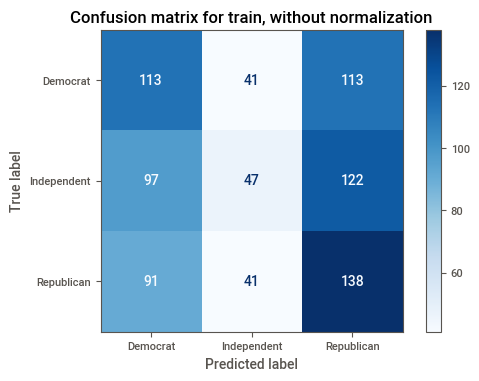

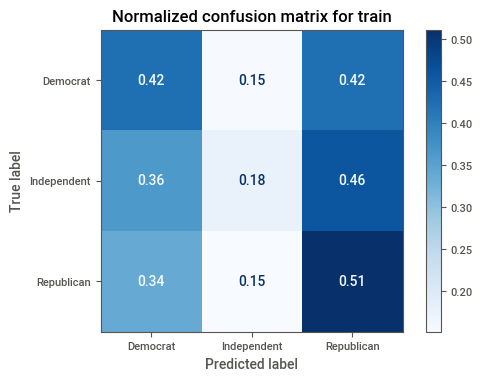

In [223]:
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, without normalization
[[32 10 27]
 [27 10 34]
 [23  8 30]]
Normalized confusion matrix for test
[[0.46376812 0.14492754 0.39130435]
 [0.38028169 0.14084507 0.47887324]
 [0.37704918 0.13114754 0.49180328]]


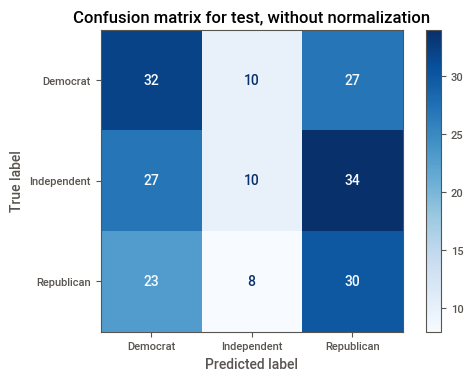

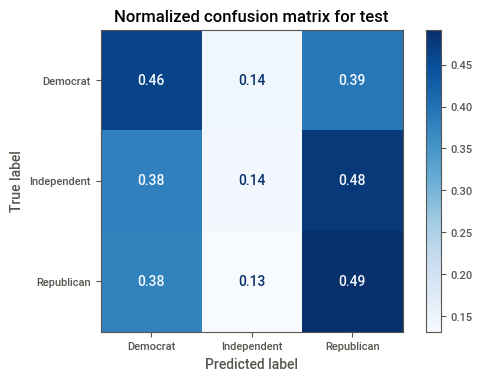

In [224]:
titles_options = [("Confusion matrix for test, without normalization", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for train, without normalization
[[115  40 112]
 [ 97  47 122]
 [ 91  41 138]]
Normalized confusion matrix for train
[[0.43071161 0.14981273 0.41947566]
 [0.36466165 0.17669173 0.45864662]
 [0.33703704 0.15185185 0.51111111]]


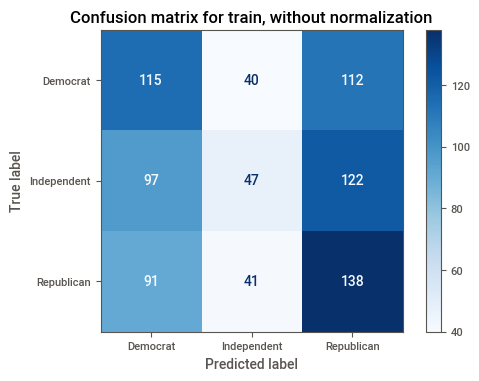

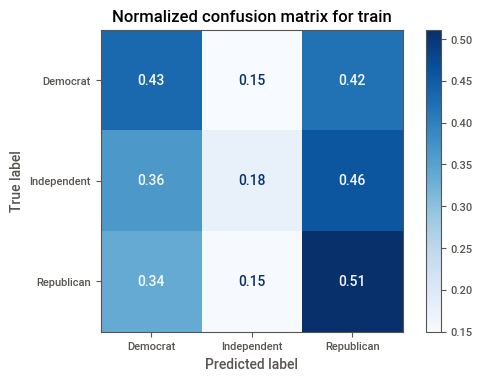

In [225]:
titles_options = [("Confusion matrix for train, without normalization", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_l1_C10['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_l1_C10, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, without normalization
[[32 10 27]
 [27 10 34]
 [23  8 30]]
Normalized confusion matrix for test
[[0.46376812 0.14492754 0.39130435]
 [0.38028169 0.14084507 0.47887324]
 [0.37704918 0.13114754 0.49180328]]


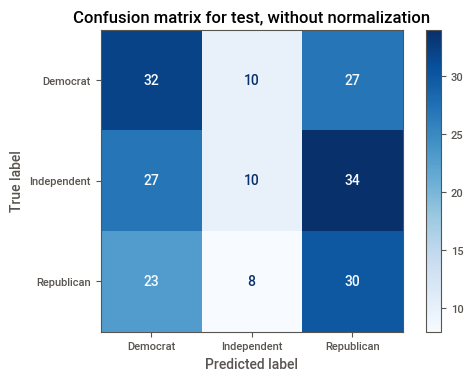

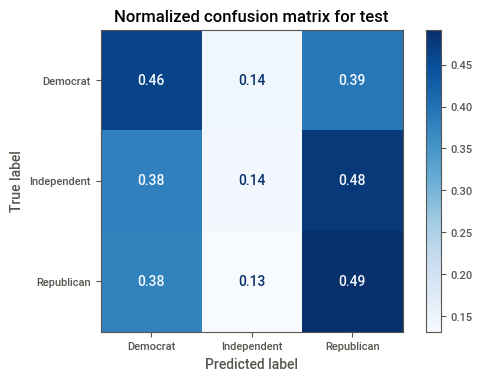

In [226]:
titles_options = [("Confusion matrix for test, without normalization", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_l1_C10['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_l1_C10, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Yep, train is bad and test is worse.  Definately NOT overfitted. lol  Neither of these 'best' models do a very good job fitting at all.  Perhaps we will have better luck with random forest.  The models are having a tough time predicting 'Independent's in particular

### Random forest model

We can use the same transformer we made above...

In [227]:
from sklearn.ensemble import RandomForestClassifier

In [228]:
# Random forest classifier
clf_model_rf = RandomForestClassifier(oob_score=True, random_state=0)

# Append classifier to preprocessing pipeline.
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_rf)])

# Fit model on training data 
clf_rf.fit(X_train, y_train)

print(f"Training score: {clf_rf.score(X_train, y_train):.3f}")
print(f"Test score: {clf_rf.score(X_test, y_test):.3f}")

Training score: 1.000
Test score: 0.383


Training score 1!  Well.. that's an indication of being overfit.  On test it only performs slightly better than the multiple regression models.  

Using the information on https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html I am going to tweak the max_depth allowed for nodes and see what happens...

In [229]:
# 2nd Random forest classifier
clf_model_rf2 = RandomForestClassifier(max_depth=4, random_state=0)

# Append classifier to preprocessing pipeline.
clf_rf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf_model_rf2)])

# Fit model on training data 
clf_rf2.fit(X_train, y_train)

print(f"Training score: {clf_rf2.score(X_train, y_train):.3f}")
print(f"Test score: {clf_rf2.score(X_test, y_test):.3f}")

Training score: 0.626
Test score: 0.413


That took care of the overfitting, but only slightly improved the prediction to 41%

#### Random forest Matrix's

Let's look at the confusion matrix's for the Random forest models (clf_rf & clf_rf2)

Confusion matrix for train, 1st random forest model
[[267   0   0]
 [  0 266   0]
 [  0   0 270]]
Normalized confusion matrix for train
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


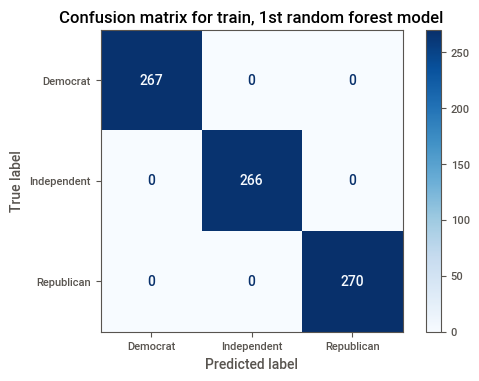

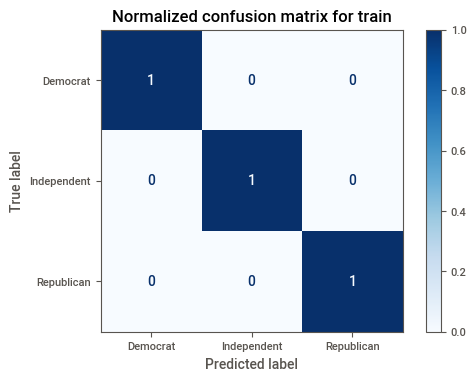

In [230]:
titles_options = [("Confusion matrix for train, 1st random forest model", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_rf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, 1st random forest model
[[33 15 21]
 [30 25 16]
 [18 24 19]]
Normalized confusion matrix for test
[[0.47826087 0.2173913  0.30434783]
 [0.42253521 0.35211268 0.22535211]
 [0.29508197 0.39344262 0.31147541]]


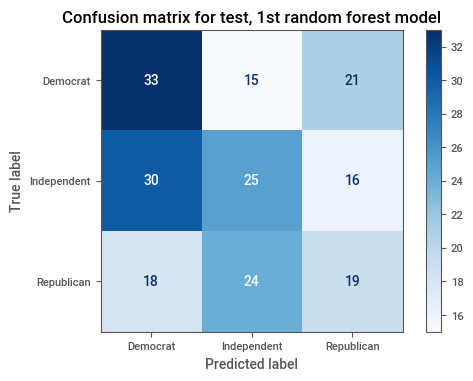

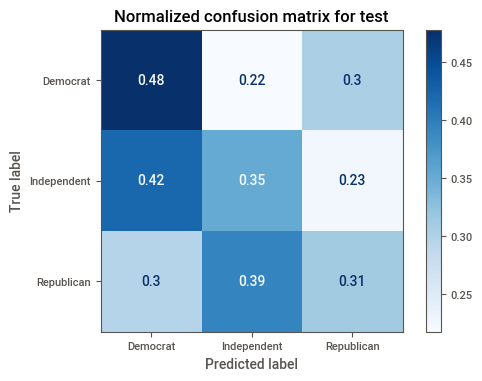

In [231]:
titles_options = [("Confusion matrix for test, 1st random forest model", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_rf['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for train, 2nd random forest model
[[171  28  68]
 [ 47 158  61]
 [ 59  37 174]]
Normalized confusion matrix for train
[[0.64044944 0.10486891 0.25468165]
 [0.17669173 0.59398496 0.22932331]
 [0.21851852 0.13703704 0.64444444]]


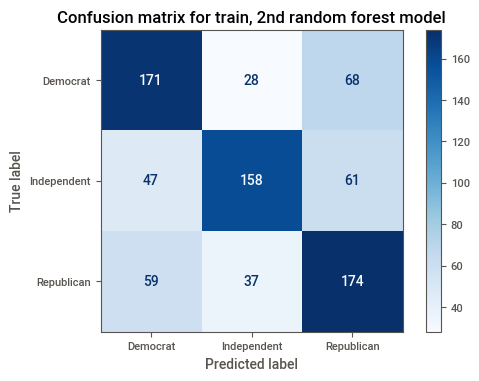

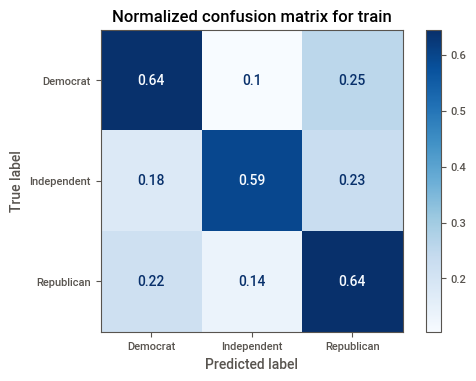

In [232]:
titles_options = [("Confusion matrix for train, 2nd random forest model", None),
                  ("Normalized confusion matrix for train", 'true')]

class_names = clf_rf2['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf2, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix for test, 2nd random forest model
[[28 14 27]
 [19 28 24]
 [19 15 27]]
Normalized confusion matrix for test
[[0.4057971  0.20289855 0.39130435]
 [0.26760563 0.3943662  0.33802817]
 [0.31147541 0.24590164 0.44262295]]


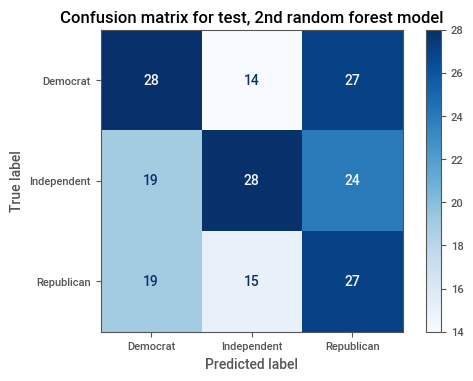

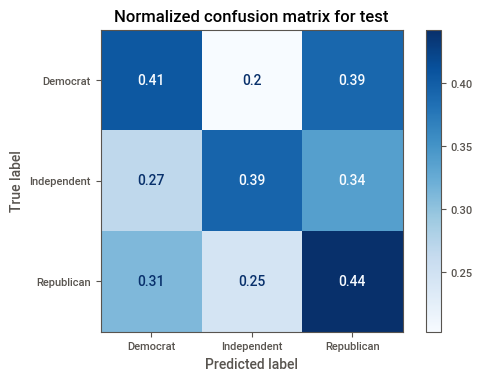

In [233]:
titles_options = [("Confusion matrix for test, 2nd random forest model", None),
                  ("Normalized confusion matrix for test", 'true')]

class_names = clf_rf2['classifier'].classes_

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf2, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

My 2nd Random forest model is predicting all 3 parties at a similar success rate, with Independants still being the hardest to predict.

## Conclusion

My best model clf_rf2 only predicted Political Party with 41% accuracy on test data.  Not great.  Some thoughts about how I could improve this score include playing around with bucketing HHI & HHDL variables and testing out other types of models. In a perfect world more data might be helpful as well.

I definately appreciated the pipeline feature of this assignment, as it made running additional models and confusion matrixes very easy